In [1]:
# Setup
import os
import requests
import zipfile
import shutil
import pandas as pd
import xml.etree.ElementTree as ET
from io import BytesIO
from IPython.display import Image, display

# Config
SHEET_ID = "1BTGt7NIDaNVrWS1mmmGrZZ_k3xAUWrTMJdCMiZGd1sk"
GID = "0"
IMAGE_FOLDER = "food_images"

print("✅ Setup complete!")

✅ Setup complete!


In [2]:
# STEP 1: Download CSV data
csv_url = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={GID}"
df = pd.read_csv(csv_url)

print(f"✅ Loaded {len(df)} rows")
print(f"Columns: {list(df.columns)}\n")
display(df.head())

✅ Loaded 90 rows
Columns: ['Nomor', 'Nama', 'Foto', 'Nama Makanan', 'Nama File (tambah .jpg)', 'Harga', 'Kalori (kkal)', 'Unnamed: 7']



,Nomor,Nama,Foto,Nama Makanan,Nama File (tambah .jpg),Harga,Kalori (kkal),Unnamed: 7
0,1,Fayza,NaN,Nasi Alo Bistik,Nasi Alo Bistik.jpg,Rp20.000,600 kkal,"Notes: Biar rapih, pilihnya yg insert gambar k..."
1,2,NaN,NaN,Pizza Margarita,Pizza Margarita.jpg,Rp22.000,2000 kkal,NaN
2,3,NaN,NaN,Nasi Ikan fillet asam manis capcay,Nasi Ikan fillet asam manis capcay.jpg,Rp19.000,650 kkal,Tambun
3,4,NaN,NaN,Nasi Ayam Hainan,Nasi Ayam Hainan.jpg,Rp19.000,550 kkal,NaN
4,5,NaN,NaN,Nasi Bebek Madura,Nasi Bebek Madura.jpg,Rp19.000,900 kkal,NaN


In [3]:
# STEP 2: Download XLSX dan parse image positions dari XML
xlsx_url = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=xlsx"

print("📥 Downloading XLSX...")
response = requests.get(xlsx_url, timeout=30)
xlsx_bytes = BytesIO(response.content)

# Parse XML untuk dapat row position tiap image
image_to_row = {}

with zipfile.ZipFile(xlsx_bytes, 'r') as zip_ref:
    # Parse drawing XML
    drawing_files = [f for f in zip_ref.namelist() if 'drawing' in f and f.endswith('.xml')]
    
    for drawing_file in drawing_files:
        drawing_xml = zip_ref.read(drawing_file).decode('utf-8')
        root = ET.fromstring(drawing_xml)
        
        ns = {
            'xdr': 'http://schemas.openxmlformats.org/drawingml/2006/spreadsheetDrawing',
            'a': 'http://schemas.openxmlformats.org/drawingml/2006/main'
        }
        
        for anchor in root.findall('.//xdr:oneCellAnchor', ns) + root.findall('.//xdr:twoCellAnchor', ns):
            from_elem = anchor.find('.//xdr:from', ns)
            if from_elem is not None:
                row_elem = from_elem.find('.//xdr:row', ns)
                if row_elem is not None:
                    row_num = int(row_elem.text)
                    
                    pic = anchor.find('.//xdr:pic', ns)
                    if pic is not None:
                        cnvpr = pic.find('.//xdr:nvPicPr/xdr:cNvPr', ns)
                        if cnvpr is not None:
                            img_name = cnvpr.get('name')
                            if img_name:
                                image_to_row[img_name] = row_num

print(f"✅ Found {len(image_to_row)} images with row positions")

📥 Downloading XLSX...


✅ Found 90 images with row positions


In [4]:
# STEP 3: Extract images dari XLSX
if os.path.exists(IMAGE_FOLDER):
    shutil.rmtree(IMAGE_FOLDER)

os.makedirs(IMAGE_FOLDER, exist_ok=True)

with zipfile.ZipFile(xlsx_bytes, 'r') as zip_ref:
    media_files = [f for f in zip_ref.namelist() if f.startswith('xl/media/')]
    
    for media_file in media_files:
        img_data = zip_ref.read(media_file)
        img_name = os.path.basename(media_file)
        save_path = os.path.join(IMAGE_FOLDER, img_name)
        
        with open(save_path, 'wb') as f:
            f.write(img_data)

print(f"✅ Extracted {len(media_files)} images to {IMAGE_FOLDER}/")

✅ Extracted 90 images to food_images/


In [5]:
# STEP 4: Rename images berdasarkan row position
print("🔄 Renaming images...\n")

renamed_count = 0
errors = []

for img_name, row_idx in image_to_row.items():
    # row_idx dari XML: 0=header, 1=data row 1
    # df index: 0=data row 1
    df_idx = row_idx - 1
    
    if df_idx >= 0 and df_idx < len(df):
        row_data = df.iloc[df_idx]
        new_name = str(row_data['Nama File (tambah .jpg)']).strip()
        
        if new_name and new_name != 'nan':
            old_path = os.path.join(IMAGE_FOLDER, img_name)
            new_path = os.path.join(IMAGE_FOLDER, new_name)
            
            if os.path.exists(old_path):
                # Handle duplicates
                if os.path.exists(new_path) and old_path != new_path:
                    base, ext = os.path.splitext(new_name)
                    new_name = f"{base}_{df_idx+1}{ext}"
                    new_path = os.path.join(IMAGE_FOLDER, new_name)
                
                try:
                    shutil.move(old_path, new_path)
                    renamed_count += 1
                    if renamed_count <= 10:
                        print(f"  ✅ Row {row_idx+1}: {img_name} → {new_name}")
                except Exception as e:
                    errors.append(f"Row {row_idx+1}: {img_name} - {e}")

if renamed_count > 10:
    print(f"  ... and {renamed_count - 10} more")

print(f"\n✅ Successfully renamed {renamed_count} images!")
if errors:
    print(f"\n⚠️ {len(errors)} errors:")
    for err in errors[:5]:
        print(f"  {err}")

🔄 Renaming images...

  ✅ Row 2: image12.jpg → Nasi Alo Bistik.jpg
  ✅ Row 3: image4.jpg → Pizza Margarita.jpg
  ✅ Row 4: image59.jpg → Nasi Ikan fillet asam manis  capcay.jpg
  ✅ Row 5: image20.jpg → Nasi Ayam Hainan.jpg
  ✅ Row 6: image1.jpg → Nasi Bebek Madura.jpg
  ✅ Row 7: image6.jpg → Bubur Ayam.jpg
  ✅ Row 8: image86.jpg → Nasi Ayam Bakar Kremes.jpg
  ✅ Row 9: image10.jpg → Takoyaki.jpg
  ✅ Row 10: image5.jpg → Ketoprak Telor.jpg
  ✅ Row 11: image7.jpg → Ramen Kuah.jpg
  ... and 80 more

✅ Successfully renamed 90 images!


🔍 Verifying random samples:


📋 Row 10: Ramen Kuah
   File: Ramen Kuah.jpg
   Exists: ✅


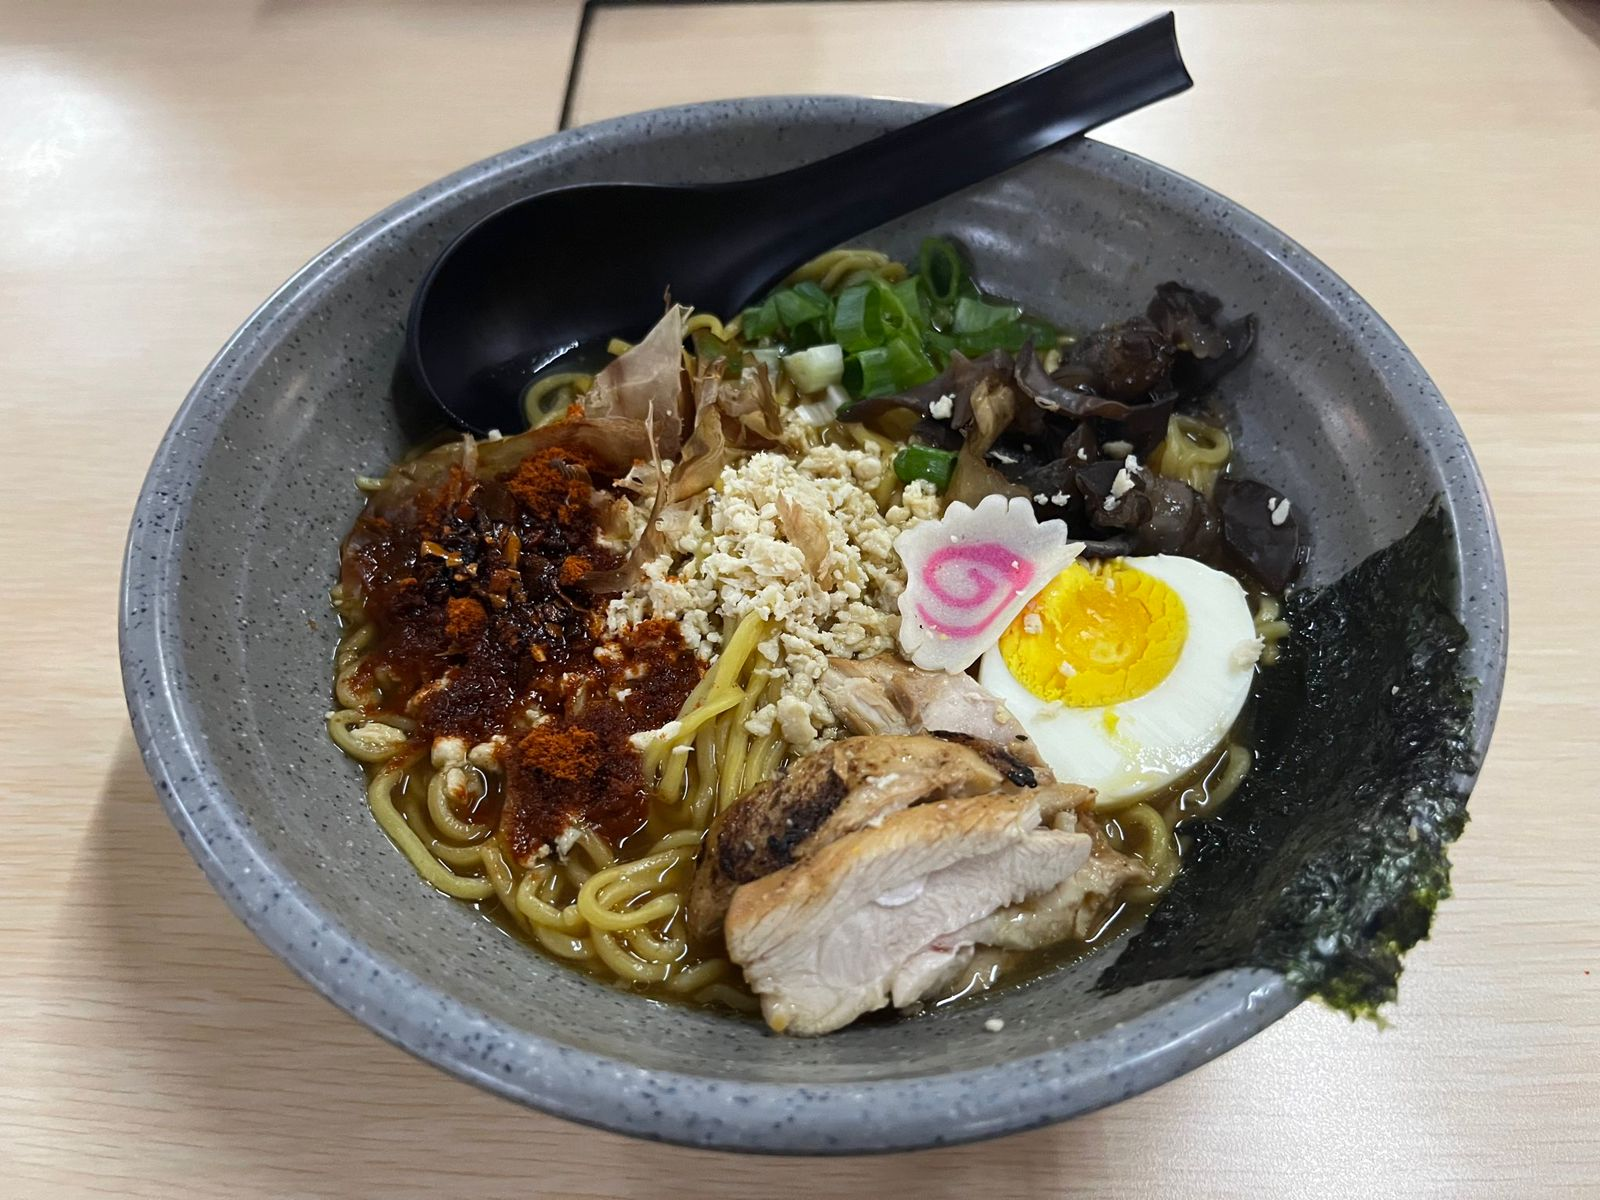

--------------------------------------------------------------------------------

📋 Row 37: Pisang Goreng Milo
   File: Pisang Goreng Milo.jpg
   Exists: ✅


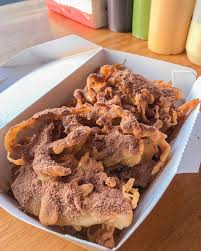

--------------------------------------------------------------------------------

📋 Row 87: Sate Ayam
   File: Sate Ayam.jpg
   Exists: ✅


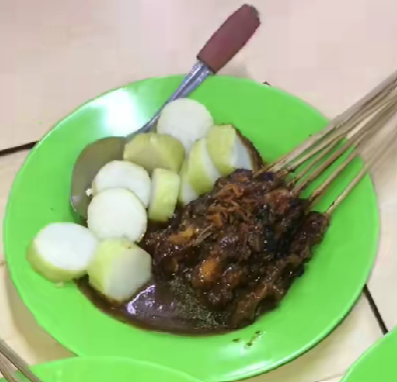

--------------------------------------------------------------------------------

📋 Row 58: Cipuk (8pcs)
   File: Cipuk (8pcs).jpg
   Exists: ✅


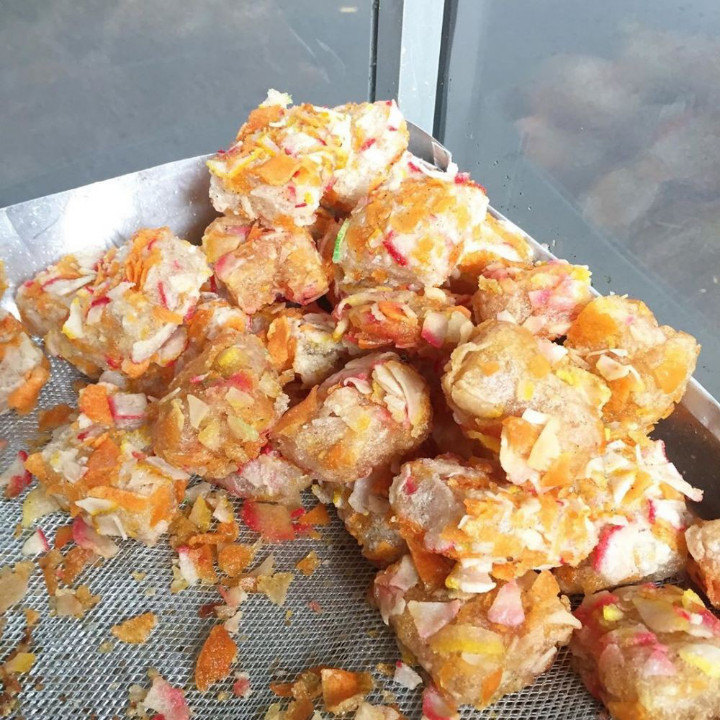

--------------------------------------------------------------------------------

📋 Row 15: Tempe Mendoan
   File: Tempe Mendoan.jpg
   Exists: ✅


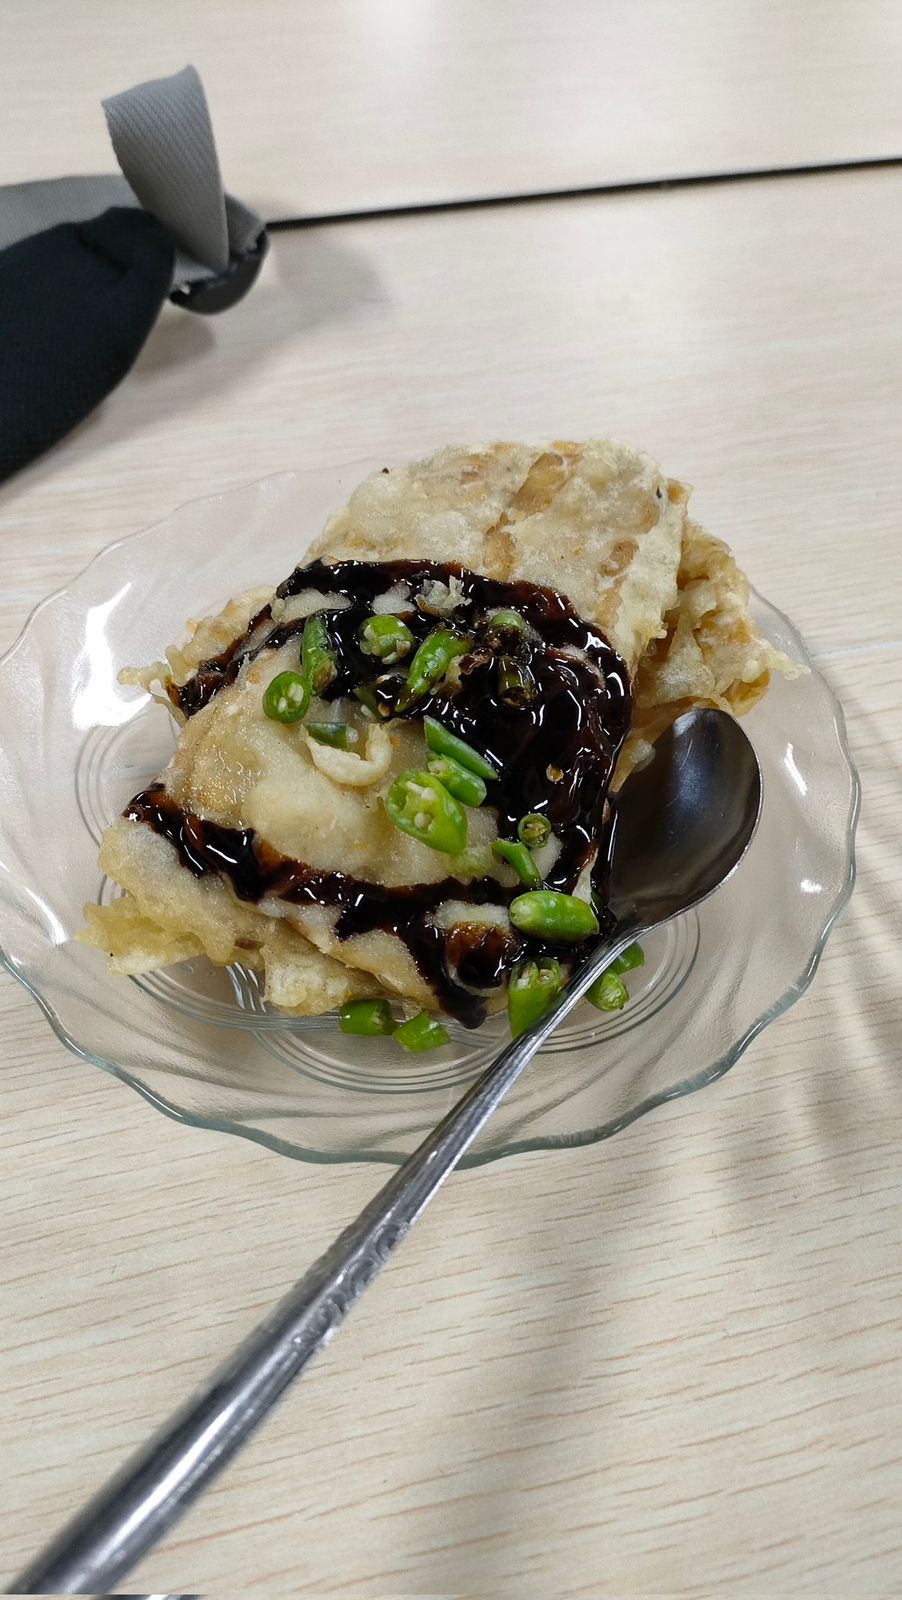

--------------------------------------------------------------------------------


In [6]:
# STEP 5: Verify dengan preview random samples
import random

sample_indices = random.sample(range(len(df)), min(5, len(df)))

print("🔍 Verifying random samples:\n")
print("=" * 80)

for idx in sample_indices:
    row_data = df.iloc[idx]
    nama_makanan = row_data['Nama Makanan']
    nama_file = row_data['Nama File (tambah .jpg)']
    img_path = os.path.join(IMAGE_FOLDER, nama_file)
    
    print(f"\n📋 Row {idx + 1}: {nama_makanan}")
    print(f"   File: {nama_file}")
    print(f"   Exists: {'✅' if os.path.exists(img_path) else '❌'}")
    
    if os.path.exists(img_path):
        try:
            display(Image(filename=img_path, width=300))
        except:
            print("   (Cannot display)")
    
    print("-" * 80)

In [7]:
# STEP 6: Generate JSON metadata untuk backend
import json

food_data = []

for i, row in df.iterrows():
    nama_file = str(row['Nama File (tambah .jpg)']).strip()
    nama_makanan = str(row['Nama Makanan']).strip()
    harga = str(row['Harga']).strip()
    kalori_str = str(row['Kalori (kkal)']).replace('kkal', '').replace(' ', '').strip()
    
    try:
        kalori = int(kalori_str)
    except:
        kalori = 0
    
    food_item = {
        "id": i + 1,
        "name": nama_makanan,
        "image": nama_file,
        "price": harga,
        "calories": kalori
    }
    food_data.append(food_item)

json_path = "food_metadata.json"
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(food_data, f, indent=2, ensure_ascii=False)

print(f"✅ Saved {len(food_data)} items to {json_path}")
print(f"\nPreview:")
for item in food_data[:3]:
    print(f"  {item['name']}: {item['image']} | {item['price']} | {item['calories']} kcal")

✅ Saved 90 items to food_metadata.json

Preview:
  Nasi Alo Bistik: Nasi Alo Bistik.jpg | Rp20.000 | 600 kcal
  Pizza Margarita: Pizza Margarita.jpg | Rp22.000 | 2000 kcal
  Nasi Ikan fillet asam manis  capcay: Nasi Ikan fillet asam manis  capcay.jpg | Rp19.000 | 650 kcal


---

## Integration ke Backend (CLIP + FAISS)

In [8]:
# Setup
import os
import requests
import zipfile
import shutil
import pandas as pd
import xml.etree.ElementTree as ET
from io import BytesIO
from IPython.display import Image, display

In [9]:
# STEP 7: Copy images dan metadata ke backend
BACKEND_DATA_DIR = "../backend/data"
BACKEND_IMAGES_DIR = os.path.join(BACKEND_DATA_DIR, "food_images")
BACKEND_METADATA = os.path.join(BACKEND_DATA_DIR, "food_metadata.json")

print("📦 Copying files to backend...\\n")

# Backup old data
if os.path.exists(BACKEND_IMAGES_DIR):
    backup_dir = f"{BACKEND_IMAGES_DIR}_backup"
    if os.path.exists(backup_dir):
        shutil.rmtree(backup_dir)
    shutil.move(BACKEND_IMAGES_DIR, backup_dir)
    print(f"✅ Backed up old images to {backup_dir}")

if os.path.exists(BACKEND_METADATA):
    shutil.copy(BACKEND_METADATA, f"{BACKEND_METADATA}.backup")
    print(f"✅ Backed up old metadata")

# Copy new files
shutil.copytree(IMAGE_FOLDER, BACKEND_IMAGES_DIR)
print(f"\\n✅ Copied {len(os.listdir(BACKEND_IMAGES_DIR))} images to {BACKEND_IMAGES_DIR}")

shutil.copy(json_path, BACKEND_METADATA)
print(f"✅ Copied metadata to {BACKEND_METADATA}")

print(f"\\n🎉 All files copied to backend!")

📦 Copying files to backend...\n
\n✅ Copied 90 images to ../backend/data/food_images
✅ Copied metadata to ../backend/data/food_metadata.json
\n🎉 All files copied to backend!


In [11]:
# STEP 8: Rebuild FAISS index dengan CLIP embeddings
print("🔨 Building FAISS index...")
print("⏳ This may take a few minutes...\n")

# Run build_index script directly
import subprocess
import sys

# Get the conda python path for dnai environment
result = subprocess.run(
    ["conda", "run", "-n", "dnai", "python", "scripts/build_index.py"],
    cwd="/Users/mraffyzeidan/Learning/DNAI/backend",
    capture_output=True,
    text=True,
    input="y\n"  # Auto-answer yes to rebuild
)

print(result.stdout)
if result.stderr:
    # Filter out common warnings
    stderr_lines = [l for l in result.stderr.split('\n') if 'warning' not in l.lower() and l.strip()]
    if stderr_lines:
        print("⚠️ Stderr:", '\n'.join(stderr_lines[:5]))

if result.returncode == 0:
    print("\n✅ FAISS index successfully built!")
    print("\n🎉 Integration complete! Backend ready to use.")
else:
    print(f"\n❌ Error: Return code {result.returncode}")
    print("Try running manually: cd backend && conda run -n dnai python scripts/build_index.py")

🔨 Building FAISS index...
⏳ This may take a few minutes...


⚠️ Stderr: EnvironmentLocationNotFound: Not a conda environment: /Users/mraffyzeidan/anaconda3/envs/dnai

❌ Error: Return code 1
Try running manually: cd backend && conda run -n dnai python scripts/build_index.py

⚠️ Stderr: EnvironmentLocationNotFound: Not a conda environment: /Users/mraffyzeidan/anaconda3/envs/dnai

❌ Error: Return code 1
Try running manually: cd backend && conda run -n dnai python scripts/build_index.py
